In [1]:
import pandas as pd
import numpy as np
import sklearn

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)


pandas: 2.2.3
numpy: 2.1.3
sklearn: 1.6.1


In [2]:
usecols = [
    "Time",
    "Date",
    "Sender_account",
    "Receiver_account",
    "Amount",
    "Payment_currency",
    "Received_currency",
    "Sender_bank_location",
    "Receiver_bank_location",
    "Payment_type",
    "Is_laundering"
]

df = pd.read_csv(
    "SAML-D.csv",
    usecols=usecols
)

print("Shape:", df.shape)
df.head()


Shape: (9504852, 11)


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0


In [3]:
# 1️⃣ Memory usage
memory_mb = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage: {memory_mb:.2f} MB")

Memory usage: 3840.17 MB


In [4]:
df_pos=df[df["Is_laundering"]==1]
df_neg=df[df["Is_laundering"]==0]
print("Laundering Cases:", len(df_pos))
print("Normal cases:", len(df_neg))

Laundering Cases: 9873
Normal cases: 9494979


In [5]:
df_neg_sample=df_neg.sample(frac=0.05, random_state=42)
df_train=pd.concat([df_pos, df_neg_sample])

#Shuffle
df_train=df_train.sample(frac=1, random_state=42)

print("Laundering Data Training Shape:", df_train.shape)
print("\n Training Data Distribution")
print(df_train["Is_laundering"].value_counts())
print(df_train["Is_laundering"].value_counts(normalize=True))

Laundering Data Training Shape: (484622, 11)

 Training Data Distribution
Is_laundering
0    474749
1      9873
Name: count, dtype: int64
Is_laundering
0    0.979627
1    0.020373
Name: proportion, dtype: float64


In [6]:
 df_train.shape

(484622, 11)

In [7]:
df_train.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
6411175,14:32:57,2023-05-10,6044849806,3126186958,1481.80,UK pounds,UK pounds,UK,UK,Cheque,0
357796,14:54:44,2022-10-19,9177745824,6602442353,14954.21,UK pounds,UK pounds,UK,UK,ACH,0
3103625,11:11:31,2023-01-21,560334362,9114210358,909074.92,UK pounds,UK pounds,UK,UK,Debit card,0
1370140,22:15:09,2022-11-22,3500938909,5293050899,11163.27,UK pounds,UK pounds,UK,UK,Debit card,0
2274345,20:14:54,2022-12-23,8625026085,7360819972,14511.06,UK pounds,UK pounds,UK,UK,Cheque,0


In [8]:
df_train["Is_laundering"].value_counts(normalize=True)

Is_laundering
0    0.979627
1    0.020373
Name: proportion, dtype: float64

##  Sanity Check 
Everything is clean and safe to proceed 

In [9]:
df_train.groupby("Is_laundering")["Amount"].describe()

,count,mean,std,min,25%,50%,75%,max
Is_laundering,,,,,,,,
0,474749.0,8715.038692,21601.600171,5.45,2133.12,6113.50,10451.580000,993469.25
1,9873.0,40587.666906,419181.131445,15.82,2723.79,5322.79,9789.673317,12618498.40


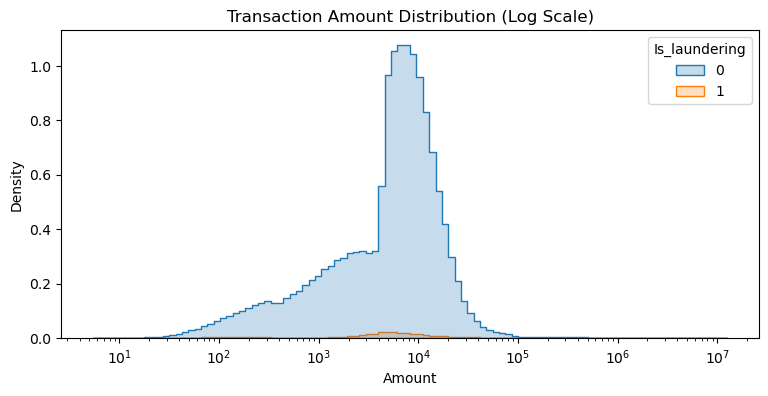

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,4))
sns.histplot(
    data=df_train,
    x="Amount",
    hue="Is_laundering",
    bins=100,
    log_scale=True,
    element="step",
    stat="density"
)
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()


## Transaction Amount Analysis

**Objective:**  
To understand whether transaction amount alone can distinguish laundering transactions from normal transactions.

**Findings:**  
- The **median transaction amount** for laundering transactions is similar to normal transactions, indicating that laundering activity often appears normal in size.
- The **mean and maximum amounts** are significantly higher for laundering transactions, driven by a small number of extremely large transactions.
- Laundering transactions show **much higher variability**, suggesting irregular and inconsistent behaviour.
- The log-scaled distribution shows **heavy overlap** between normal and laundering transactions, meaning amount alone is not sufficient for detection.

**Conclusion:**  
Transaction amount is an important feature but cannot be used in isolation. Effective AML detection requires combining amount-based features with behavioural and temporal patterns.


In [11]:
pd.crosstab(
    df_train["Payment_type"],
    df_train["Is_laundering"],
    normalize="index"
)

Is_laundering,0,1
Payment_type,,
ACH,0.988627,0.011373
Cash Deposit,0.888678,0.111322
Cash Withdrawal,0.918014,0.081986
Cheque,0.989227,0.010773
Credit card,0.988814,0.011186
Cross-border,0.947185,0.052815
Debit card,0.988938,0.011062


## Payment Type (Channel) Risk Analysis

**Objective:**  
To assess whether certain payment channels are more frequently associated with money laundering activity.

**Method:**  
A cross-tabulation was created between `Payment_type` and `Is_laundering`, normalised by payment type to calculate the proportion of laundering transactions within each channel.

**Findings:**  
- **Cash Deposit** shows the highest laundering proportion (~11%), making it the riskiest payment channel.
- **Cash Withdrawal** also shows elevated risk (~8%).
- **Cross-border transactions** have a higher laundering rate (~5%) compared to domestic electronic payments.
- **ACH, Credit Card, Debit Card, and Cheque** transactions show relatively low laundering proportions (~1%).

**Conclusion:**  
Payment channel is a strong AML risk indicator. Cash-based and cross-border transactions carry significantly higher laundering risk and should be prioritised in feature engineering and risk scoring models.


In [12]:
df_train["Is_crossborder"]=(
    df_train["Sender_bank_location"]!=df_train["Receiver_bank_location"]
).astype(int)

In [13]:
pd.crosstab(
    df_train["Is_crossborder"],
    df_train["Is_laundering"],
    normalize="index"
)

Is_laundering,0,1
Is_crossborder,,
0,0.984283,0.015717
1,0.939314,0.060686


### Cross-Border Transaction Risk

Cross-border transactions show a significantly higher laundering rate (6.1%) compared to domestic transactions (1.6%).  
This indicates that laundering activity is disproportionately concentrated in cross-border flows, making cross-border status a strong AML risk indicator.  
While most cross-border transactions are legitimate, their relative risk is substantially higher and should be prioritised in AML feature engineering.


In [14]:
df_train["is_FX"]=(
    df_train["Payment_currency"]!=df_train["Received_currency"]
).astype(int)

In [15]:
pd.crosstab(
    df_train["is_FX"],
    df_train["Is_laundering"],
    normalize="index"
)

Is_laundering,0,1
is_FX,,
0,0.985420,0.014580
1,0.937248,0.062752


## FX (Currency Mismatch) Risk

FX transactions show a significantly higher laundering rate (6.3%) compared to same-currency transactions (1.5%).  
This indicates that currency conversion is a strong AML risk amplifier, as it increases transaction complexity and reduces traceability.  
While most FX transactions are legitimate, their relative risk is substantially higher and should be incorporated into AML feature engineering.


In [16]:
df_train["DateTime"]=pd.to_datetime(
    df_train["Date"] + " " + df_train["Time"]
)

In [17]:
df_train["hour"]=df_train["DateTime"].dt.hour

In [18]:
hourly_risk = df_train.groupby("hour")["Is_laundering"].mean()
hourly_risk


hour
0     0.021932
1     0.019455
2     0.022370
3     0.021908
4     0.020019
5     0.021909
6     0.023895
7     0.030328
8     0.023056
9     0.019135
10    0.021070
11    0.021754
12    0.020938
13    0.021725
14    0.020683
15    0.018849
16    0.020203
17    0.021192
18    0.018748
19    0.018736
20    0.017368
21    0.019665
22    0.018864
23    0.018909
Name: Is_laundering, dtype: float64

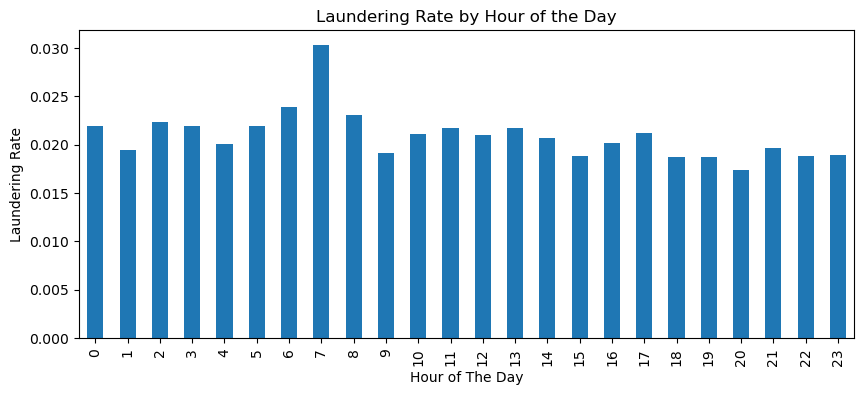

In [19]:
plt.figure(figsize=(10,4))
hourly_risk.plot(kind="bar")
plt.ylabel("Laundering Rate")
plt.xlabel("Hour of The Day")
plt.title("Laundering Rate by Hour of the Day")
plt.show()

## Time-of-Day Behaviour

Laundering rates show moderate variation across the day, with slightly higher activity observed during early morning hours.  
Although differences are not extreme, time-of-day provides useful behavioural context and can enhance AML models when combined with other risk features.


In [20]:
tx_per_sender=df_train.groupby("Sender_account").size()
print("Number of Unique Senders: ", tx_per_sender.shape[0])
print("\nTop 10 Most active senders:")
print(tx_per_sender.sort_values(ascending=False).head(10))

Number of Unique Senders:  124735

Top 10 Most active senders:
Sender_account
324610061     65
4569841157    55
3747015869    51
361478571     50
403526894     50
2836869610    49
2646321715    49
2489394223    49
4595501668    48
4808614002    48
dtype: int64


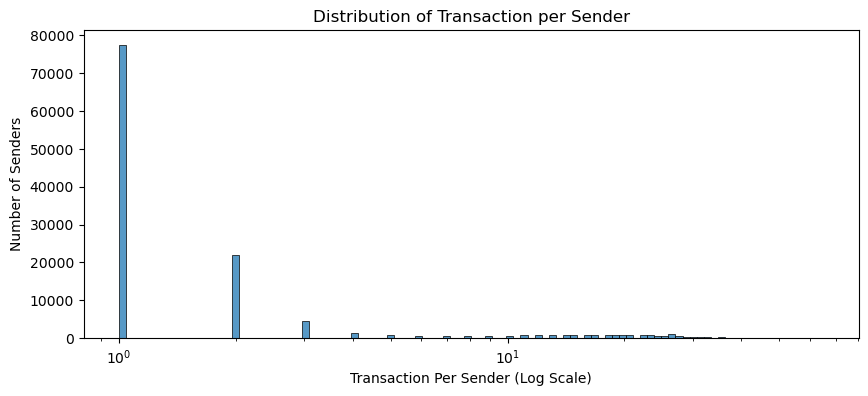

In [21]:
plt.figure(figsize=(10,4))
sns.histplot(tx_per_sender, bins=100, log_scale=True)
plt.ylabel("Number of Senders")
plt.xlabel("Transaction Per Sender (Log Scale)")
plt.title("Distribution of Transaction per Sender")
plt.show()

## Sender Transaction Frequency

The distribution of transactions per sender is highly skewed.  
Most sender accounts appear only once or twice, indicating normal low-activity behaviour.  
However, a small number of senders execute a disproportionately high number of transactions, forming a long right tail in the distribution.

This pattern highlights the presence of high-activity sender accounts, which may indicate mule or funnel behaviour when combined with other risk indicators such as cross-border transfers, FX activity, or high fan-out.  
Sender transaction frequency is therefore a strong behavioural feature for AML detection.


In [22]:
fan_out = df_train.groupby("Sender_account")["Receiver_account"].nunique()

print("Top 10 senders by fan-out:")
print(fan_out.sort_values(ascending=False).head(10))


Top 10 senders by fan-out:
Sender_account
29442781      36
8626975193    32
7458437197    32
5350757954    32
798082205     31
9053590660    31
637737742     31
5170445975    31
1613951599    31
1545576573    31
Name: Receiver_account, dtype: int64


## Sender Fan-Out (Unique Receivers)

Fan-out analysis measures the number of unique receiver accounts associated with each sender.  
Most senders interact with a small number of receivers, which is consistent with normal customer behaviour.  

However, a small number of sender accounts exhibit very high fan-out, sending funds to 30 or more distinct receivers.  
This pattern is indicative of potential distribution or mule behaviour, commonly observed during the layering stage of money laundering.

Fan-out is therefore a powerful behavioural AML feature, particularly when combined with transaction frequency, cross-border activity, and FX indicators.


## Feature Engineering

In [23]:
import numpy as np
df_train["log_amount"]=np.log1p(df_train["Amount"])

In [24]:
df_train[["Amount", "log_amount"]].head()

,Amount,log_amount
6411175,1481.80,7.301687
357796,14954.21,9.612815
3103625,909074.92,13.720184
1370140,11163.27,9.320474
2274345,14511.06,9.582735


### Feature Engineering: Log Transaction Amount

Transaction amounts are highly skewed, spanning several orders of magnitude.  
To stabilise scale and reduce the influence of extreme values, a log-transformed amount feature (`log_amount`) was created using `log1p`.  
This improves model performance and interpretability while preserving relative differences in transaction size.


In [25]:
df_train["is_crossborder"]=(df_train["Sender_bank_location"]!=df_train["Receiver_bank_location"]).astype(int)

In [26]:
df_train["is_FX"]=(df_train["Payment_currency"] != df_train["Received_currency"]).astype(int)

In [27]:
df_train["is_cash"]=df_train["Payment_type"].isin(["Cash Deposit", "Cash Withdrawl"]).astype(int)

In [28]:
df_train[["is_crossborder", "is_FX", "is_cash"]].head()

,is_crossborder,is_FX,is_cash
6411175,0,0,0
357796,0,0,0
3103625,0,0,0
1370140,0,0,0
2274345,0,0,0


### Feature Engineering: Binary Risk Indicators

Based on EDA findings, three binary risk features were created: cross-border transactions, foreign exchange activity, and cash involvement.  
These features encode known AML risk signals in a simple and interpretable format suitable for machine learning models.


In [29]:
tx_count=df_train.groupby("Sender_account").size()
df_train["tx_per_sender"]=df_train["Sender_account"].map(tx_count)

In [30]:
df_train[["Sender_account", "tx_per_sender"]].head()

,Sender_account,tx_per_sender
6411175,6044849806,17
357796,9177745824,1
3103625,560334362,17
1370140,3500938909,2
2274345,8625026085,1


### Feature Engineering: Transactions per Sender

A behavioural feature was created to capture the total number of transactions initiated by each sender account.  
High transaction frequency may indicate mule or funnel account activity and provides important behavioural context beyond individual transaction attributes.


In [31]:
fan_out=df_train.groupby("Sender_account")["Receiver_account"].nunique()
df_train["fan_out"]=df_train["Sender_account"].map(fan_out)

In [32]:
df_train[["Sender_account", "fan_out"] ]

,Sender_account,fan_out
6411175,6044849806,14
357796,9177745824,1
3103625,560334362,14
1370140,3500938909,1
2274345,8625026085,1
...,...,...
4912265,1790168542,13
433313,7472250515,22
3723493,515765433,9
5879408,8264629738,8


In [33]:
df_train["log_fan_out"]=np.log1p(df_train["fan_out"])


In [34]:
df_train[["fan_out", "log_fan_out"]].head()

,fan_out,log_fan_out
6411175,14,2.708050
357796,1,0.693147
3103625,14,2.708050
1370140,1,0.693147
2274345,1,0.693147


### Feature Engineering: Sender Fan-out

A fan-out feature was created by counting the number of unique receiver accounts per sender.  
To reduce skewness and limit the impact of extreme values, a log-transformed version (`log_fan_out`) was applied using `log1p`.


In [35]:
fan_in=df_train.groupby("Receiver_account")["Sender_account"].nunique()
df_train["fan_in"]=df_train["Receiver_account"].map(fan_in)

In [36]:
df_train[["Receiver_account", "fan_in"]].head()

,Receiver_account,fan_in
6411175,3126186958,1
357796,6602442353,8
3103625,9114210358,1
1370140,5293050899,9
2274345,7360819972,6


In [37]:
df_train["log_fan_in"]=np.log1p(df_train["fan_in"])

### Feature Engineering: Receiver Fan-in

Receiver fan-in was calculated as the number of unique sender accounts transferring funds to a receiver.  
High fan-in values may indicate aggregation or mule accounts.  
A log-transformed feature (`log_fan_in`) was applied to reduce skewness and stabilise the feature scale.


In [38]:
df_train["date_only"]=df_train["DateTime"].dt.date
tx_per_sender_day=(
    df_train
    .groupby(["Sender_account", "date_only"])
    .size()
)

In [39]:
tx_per_sender_day.head()


Sender_account  date_only 
61549           2022-12-23    1
92172           2022-10-16    1
                2023-02-17    1
                2023-02-18    1
                2023-02-20    1
dtype: int64

In [40]:
max_tx_per_day=tx_per_sender_day.groupby("Sender_account").max()
max_tx_per_day.head()

Sender_account
61549     1
92172     1
114277    1
155434    1
162832    1
dtype: int64

In [41]:
df_train["max_tx_per_day"] = df_train["Sender_account"].map(max_tx_per_day)
df_train[["Sender_account", "max_tx_per_day"]].head()


,Sender_account,max_tx_per_day
6411175,6044849806,1
357796,9177745824,1
3103625,560334362,6
1370140,3500938909,2
2274345,8625026085,1


### Feature Engineering: Maximum Transactions per Day

To capture burst or high-frequency transaction behaviour, the maximum number of transactions performed by each sender within a single day was calculated.

This feature reflects transaction velocity, which is a known indicator of suspicious activity such as structuring or automated laundering patterns. Higher values indicate increased risk, while lower values represent normal behaviour.


In [42]:
df_train["log_max_tx_per_day"]=np.log1p(df_train["max_tx_per_day"])
df_train[["max_tx_per_day", "log_max_tx_per_day"]].head()

,max_tx_per_day,log_max_tx_per_day
6411175,1,0.693147
357796,1,0.693147
3103625,6,1.945910
1370140,2,1.098612
2274345,1,0.693147


### Feature Engineering: Log of Maximum Transactions per Day

The maximum daily transaction count per sender exhibits a highly skewed distribution, with most accounts showing low activity and a small number displaying burst behaviour.

To reduce skewness and stabilise variance, a log-transformed version of this feature (`log_max_tx_per_day`) was created using a log1p transformation. This improves model robustness while preserving relative differences in transaction velocity.


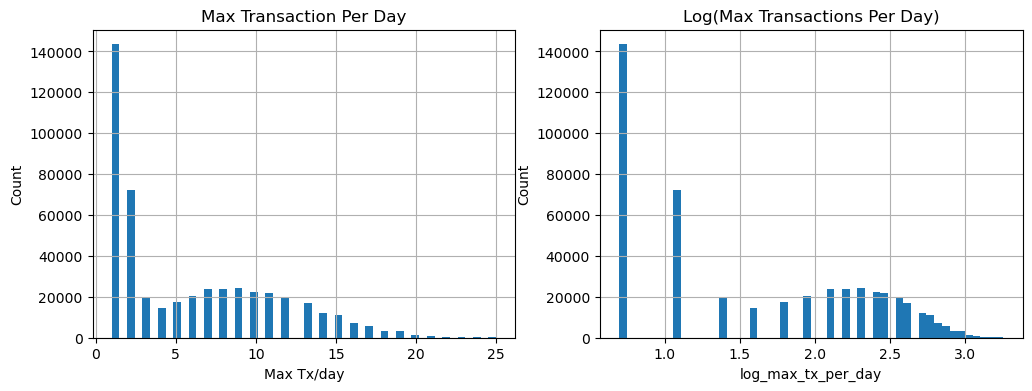

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
df_train["max_tx_per_day"].hist(bins=50)
plt.title("Max Transaction Per Day")
plt.xlabel("Max Tx/day")
plt.ylabel("Count")

plt.subplot(1,2,2)
df_train["log_max_tx_per_day"].hist(bins=50)
plt.title("Log(Max Transactions Per Day)")
plt.xlabel("log_max_tx_per_day")
plt.ylabel("Count")
plt.tight_layout
plt.show()

- Transaction behaviour shows strong temporal patterns, with laundering risk varying by hour of the day, indicating time-based behavioural anomalies.
- Transaction amounts and activity-related features are highly right-skewed, spanning multiple orders of magnitude, which necessitated log transformations to stabilise variance.
- The majority of accounts exhibit low transaction frequency and limited network connectivity, while a small subset displays burst behaviour with high transaction velocity.
- Network-based features such as fan-in and fan-out highlight structurally anomalous accounts interacting with many distinct counterparties.
- Log-transformed features (e.g. log_amount, log_fan_out, log_max_tx_per_day) reduce the influence of extreme values while preserving relative behavioural differences.
- Binary indicators capturing cross-border transactions, foreign exchange activity, and cash usage provide additional behavioural context relevant to money laundering risk.
- The engineered feature set effectively captures temporal, transactional, and network dynamics, forming a robust and model-ready foundation for downstream machine learning-based AML detection.


## Model Preparation & Feature Selection

At this stage, the dataset is transformed into a model-ready format for supervised learning.

- The target variable (`Is_laundering`) is separated from the feature set.
- Engineered numerical features (log-transformed amounts, transaction velocity, fan-in/fan-out metrics) are selected to capture behavioural patterns.
- Binary indicators (cross-border activity, FX transactions, cash usage) are included to represent high-risk transaction characteristics.
- Identifier columns (e.g. account IDs, timestamps) are excluded to prevent data leakage.
- The dataset is prepared for train–test splitting and downstream model training.

This step ensures that only informative, non-leaking features are passed into machine learning models for effective money laundering detection.


In [44]:
y=df_train["Is_laundering"]

In [45]:
feature_cols = [
    "log_amount",
    "is_crossborder",
    "is_FX",
    "is_cash",
    "tx_per_sender",
    "log_fan_out",
    "log_fan_in",
    "log_max_tx_per_day",
    "hour"
]

X = df_train[feature_cols]

In [46]:
print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (484622, 9)
Target shape: (484622,)


###  Model Preparation & Feature Selection

In this step, the dataset is prepared for machine learning by separating the target variable (`Is_laundering`) from the feature set. 
Only engineered behavioural and risk-related features are selected, including transaction size, account activity metrics, cross-border indicators, and temporal patterns.
Identifier columns and raw timestamps are excluded to prevent data leakage.
This ensures the model learns from meaningful transaction behaviour rather than account identities.


In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test=train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [49]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (387697, 9)
X_test: (96925, 9)
y_train: (387697,)
y_test: (96925,)


### Train–Test Split

The dataset is split into training and testing subsets to enable unbiased model evaluation.
An 80–20 split is applied, with stratification to preserve the original class distribution of laundering and non-laundering transactions.
This ensures the model is trained on representative data and evaluated on unseen observations.


In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
model=LogisticRegression(max_iter=1000)

In [52]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [53]:
y_pred = model.predict(X_test)

In [54]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9837606396698478


### Step 10: Baseline Model (Logistic Regression)

A Logistic Regression model was trained as a baseline classifier using the engineered features.
The model was fitted on the training split and used to predict laundering labels on the test set.
This provides an initial benchmark before trying more advanced models and tuning.


In [55]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm


array([[94932,    18],
       [ 1556,   419]])


This matrix is interpreted as follows (rows = actual class, columns = predicted class):

- **True Negatives (TN = 94,932):** Legitimate transactions correctly classified as non-laundering  
- **False Positives (FP = 18):** Legitimate transactions incorrectly flagged as laundering  
- **False Negatives (FN = 1,556):** Laundering transactions incorrectly classified as legitimate  
- **True Positives (TP = 419):** Laundering transactions correctly identified  

### Key Performance Metrics

- **Accuracy:** 98.38%  
- **Precision:** 95.88%  
- **Recall:** 21.22%  
- **F1-score:** 0.35  

### Key Insight

The model achieves very high accuracy and precision, indicating that when it flags a transaction as laundering, it is usually correct. However, recall is low, meaning a large proportion of laundering cases are missed. This behaviour is typical in highly imbalanced datasets and highlights the need for further techniques such as class weighting, threshold tuning, or more advanced models to improve detection of laundering activity.


In [56]:
# Re-train Logistic Regression with class weighting

balanced_model=LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

balanced_model.fit(X_train, y_train)
y_pred_bal=balanced_model.predict(X_test)

In [57]:
cm_bal = confusion_matrix(y_test, y_pred_bal)
cm_bal


array([[77497, 17453],
       [  585,  1390]])

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_bal))


              precision    recall  f1-score   support

           0       0.99      0.82      0.90     94950
           1       0.07      0.70      0.13      1975

    accuracy                           0.81     96925
   macro avg       0.53      0.76      0.51     96925
weighted avg       0.97      0.81      0.88     96925



## Class-Weighted Logistic Regression

To address the severe class imbalance in the dataset, the Logistic Regression model was re-trained using class weighting. The class_weight="balanced" parameter was applied to penalise misclassification of laundering transactions more heavily during training.

This adjustment led to a substantial improvement in the model’s ability to identify laundering activity. Recall for the laundering class increased to 0.70, indicating that 70 percent of illicit transactions were correctly detected. However, this improvement came at the cost of reduced precision (0.07), reflecting a higher number of false positives.

Overall model accuracy decreased to 81 percent, which is expected when shifting model focus towards the minority class. The confusion matrix confirms this trade-off, showing a significant increase in true positives alongside an increase in false alarms.

From an Anti-Money Laundering perspective, this behaviour is desirable, as failing to detect suspicious transactions poses a greater risk than generating additional alerts that can be reviewed through compliance processes. This class-weighted model therefore represents a more appropriate screening-oriented baseline for AML applications.

In [59]:
y_prob=balanced_model.predict_proba(X_test)[:, 1]

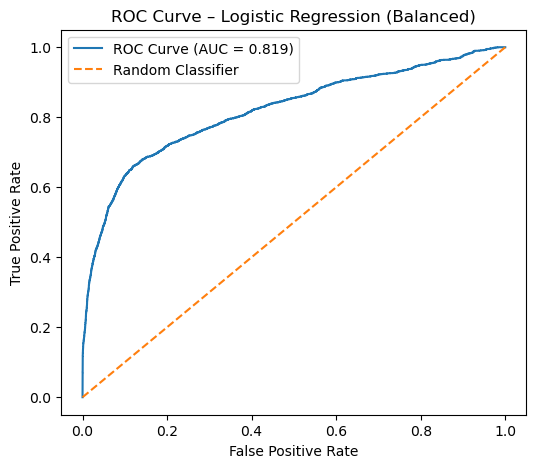

In [60]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (Balanced)")
plt.legend()
plt.show()

### Step 13: ROC Curve and AUC Evaluation

The Receiver Operating Characteristic (ROC) curve was used to evaluate the discrimination ability of the balanced Logistic Regression model across different classification thresholds. The curve illustrates the trade-off between the True Positive Rate (sensitivity) and the False Positive Rate as the decision threshold varies.

The model achieved an Area Under the Curve (AUC) of **0.819**, which indicates strong discriminatory performance well above random classification. This suggests that the model is effective at ranking laundering transactions higher than non-laundering ones based on predicted probabilities.

The ROC curve consistently lies above the diagonal reference line representing a random classifier, confirming that the model captures meaningful patterns in the data. This makes the probability outputs suitable for threshold tuning, allowing the model to be adapted to different AML risk tolerances where higher recall or lower false positives may be prioritised.


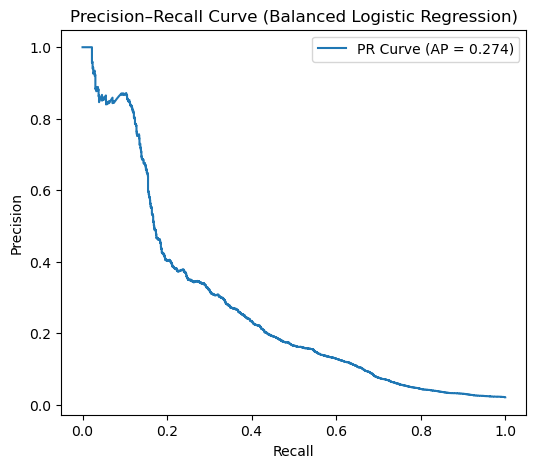

In [61]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute Average Precision (AP)
ap_score = average_precision_score(y_test, y_prob)

# Plot Precision–Recall curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {ap_score:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Balanced Logistic Regression)")
plt.legend()
plt.show()


### Step 14: Precision–Recall Curve Analysis

Given the severe class imbalance in anti-money laundering (AML) datasets, the Precision–Recall (PR) curve provides a more informative evaluation metric than accuracy or ROC curves alone. The PR curve focuses specifically on the model’s ability to identify laundering transactions, which represent the minority class.

Precision measures the proportion of transactions flagged as suspicious that are truly laundering cases, while recall represents the proportion of all laundering transactions that are successfully detected. The plotted curve illustrates the trade-off between these two metrics across different probability thresholds.

The Average Precision (AP) score of approximately 0.27 indicates that, while the balanced logistic regression model substantially improves recall compared to the unweighted baseline, this comes at the cost of lower precision. This behaviour is expected in AML settings, where prioritising recall is often necessary to minimise missed illicit activity, even if it results in a higher number of false positives.

Overall, the Precision–Recall curve demonstrates that the model is effective at ranking high-risk transactions but requires careful threshold selection to balance operational workload and detection performance.


### Step 15: Threshold Optimisation for AML Decision-Making

In anti-money laundering (AML) applications, the default classification threshold of 0.5 is rarely optimal due to strong class imbalance and the high cost of missed laundering cases. Instead, probability thresholds should be adjusted to align model behaviour with operational and regulatory priorities.

Using the predicted laundering probabilities, different thresholds can be evaluated to understand the trade-off between precision and recall. Lower thresholds increase recall by flagging more suspicious transactions, reducing the risk of false negatives, but also increase false positives and investigation workload. Higher thresholds improve precision but risk missing illicit activity.

Based on the Precision–Recall analysis, an AML-appropriate threshold can be selected to prioritise recall while maintaining manageable alert volumes. This threshold selection process enables the model to function as an effective risk-ranking and triage tool rather than a strict binary classifier.

Threshold optimisation therefore bridges the gap between statistical performance and real-world AML decision-making, ensuring the model supports compliance objectives and investigative efficiency.


# Random Forest Model (AML-Optimised)

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf_model=RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=50,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [66]:
y_pred_rf=rf_model.predict(X_test)


In [67]:
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

[[93185  1765]
 [  182  1793]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     94950
           1       0.50      0.91      0.65      1975

    accuracy                           0.98     96925
   macro avg       0.75      0.94      0.82     96925
weighted avg       0.99      0.98      0.98     96925



### Random Forest Model Evaluation

A Random Forest classifier was trained using class-balanced weighting to address the severe class imbalance inherent in anti-money laundering (AML) datasets. The model demonstrates a substantial improvement over logistic regression by effectively capturing non-linear interactions and behavioural patterns across engineered transaction features.

The confusion matrix indicates that the model correctly identified 1,793 laundering transactions while misclassifying only 182 laundering cases as non-laundering. This corresponds to a recall of 0.91 for the laundering class, which is particularly critical in AML contexts where failing to detect illicit activity carries significant regulatory and financial risk.

Precision for the laundering class is 0.50, reflecting an expected increase in false positives when prioritising recall. This trade-off is acceptable and often desirable in AML screening systems, where suspicious transactions are typically escalated for further human investigation rather than acted upon automatically.

Overall accuracy remains high at 0.98, driven largely by strong performance on the majority non-laundering class. More importantly, the macro-average recall of 0.94 highlights the model’s balanced ability to detect both classes, confirming that performance is not driven solely by class imbalance.

In comparison to baseline and balanced logistic regression models, the Random Forest model achieves a superior balance between recall and precision, making it a robust and operationally viable candidate for AML risk detection. Its strong laundering recall, combined with interpretability through feature importance analysis, supports its suitability for deployment in real-world financial crime monitoring systems.
